In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/insurance/insurance.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from scipy.special import boxcox, inv_boxcox
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read in data
data = pd.read_csv('/kaggle/input/insurance/insurance.csv')
split = round(len(data) * .8)
train = data[:split]
test = data[split:]

After splitting our dataset, it's important to verify that the target for our test dataset is distributed similarily to our train dataset.

Text(0.5, 1.0, 'Test')

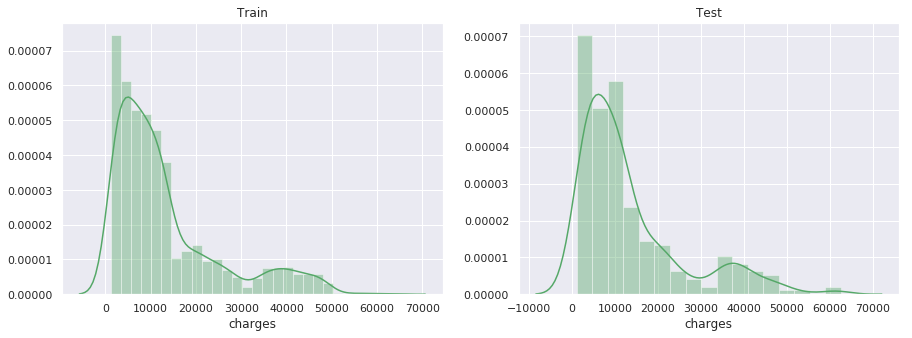

In [4]:
f, ax = plt.subplots(ncols = 2, figsize=(15,5))
sns.distplot(train['charges'], color='g', ax=ax[0])
ax[0].set_title('Train')
sns.distplot(test['charges'], color='g', ax=ax[1])
ax[1].set_title('Test')

Excellent, now lets explore our train dataset.

In [5]:
train.describe()

,age,bmi,children,charges
count,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.551402,30.782935,1.075701,13214.125813
std,14.141959,6.084472,1.191986,12033.808061
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.410000,0.000000,4740.287150
50%,40.000000,30.495000,1.000000,9333.014350
75%,51.750000,34.937500,2.000000,16547.261587
max,64.000000,52.580000,5.000000,63770.428010


In [6]:
train.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 7 columns):
age         1070 non-null int64
sex         1070 non-null object
bmi         1070 non-null float64
children    1070 non-null int64
smoker      1070 non-null object
region      1070 non-null object
charges     1070 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 58.6+ KB


In [8]:
print('Train Shape: {}'.format(train.shape))
print('Test Shape:  {}'.format(test.shape))

Train Shape: (1070, 7)
Test Shape:  (268, 7)


Let's examine numerical features in the train dataset

In [9]:
numeric_features = train.select_dtypes(include=['int64','float64']).columns
numeric_features

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

Let's examine categorical features in the train dataset

In [10]:
categorical_features = train.select_dtypes(include=['object']).columns
categorical_features

Index(['sex', 'smoker', 'region'], dtype='object')

# Univariate Analysis

### Numerical Univariate Analysis

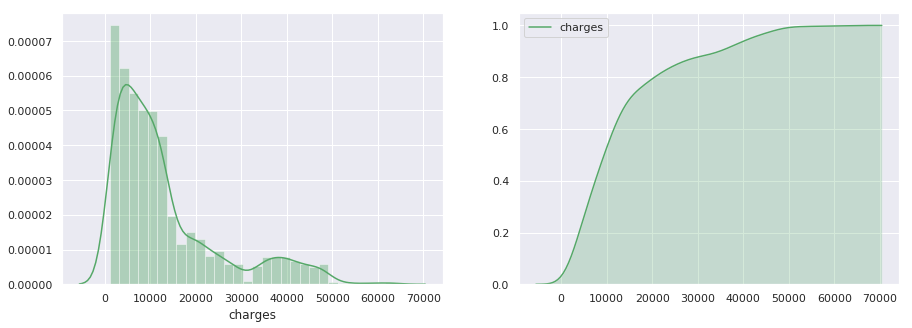

In [11]:
f, ax = plt.subplots(ncols = 2, figsize=(15,5))
sns.distplot(data['charges'], color='g', ax=ax[0])
sns.kdeplot(data['charges'], cumulative=True, shade=True, color='g', ax=ax[1])

- Medical costs for 80% of patients is approximately equal to or less than \\$20,000. 
- The range of top 20% of medical costs is roughly \\$40,000 which can have an impact on our predictions

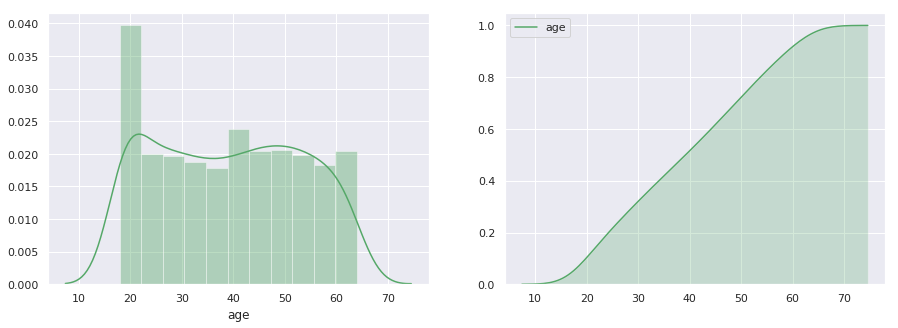

In [12]:
f, ax = plt.subplots(ncols = 2, figsize=(15,5))
sns.distplot(data['age'], color='g', ax=ax[0])
sns.kdeplot(data['age'], cumulative=True, shade=True, color='g', ax=ax[1])

- The most frequent age group is 20 year olds which is surprising -- one would expect older patients to have more frequency.
- The distribution of age is similar among the majority of age groups if we exclude the high frequency of 20 year olds

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64


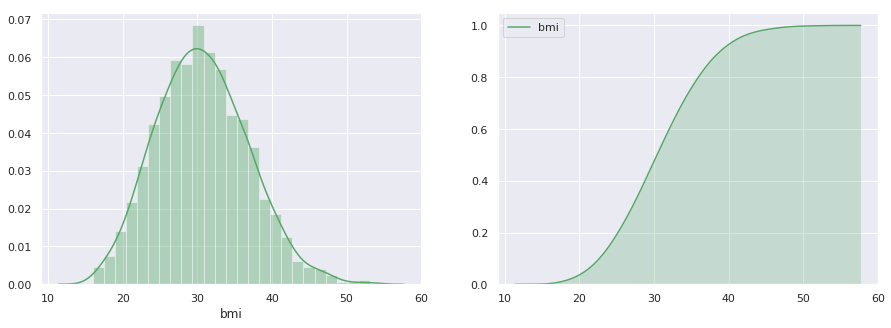

In [13]:
f, ax = plt.subplots(ncols = 2, figsize=(15,5))
sns.distplot(data['bmi'], color='g', ax=ax[0])
sns.kdeplot(data['bmi'], cumulative=True, shade=True, color='g', ax=ax[1])
print(data['bmi'].describe())

- BMI is normally distributed with an average patient having 30 bmi which is reasonable

count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64


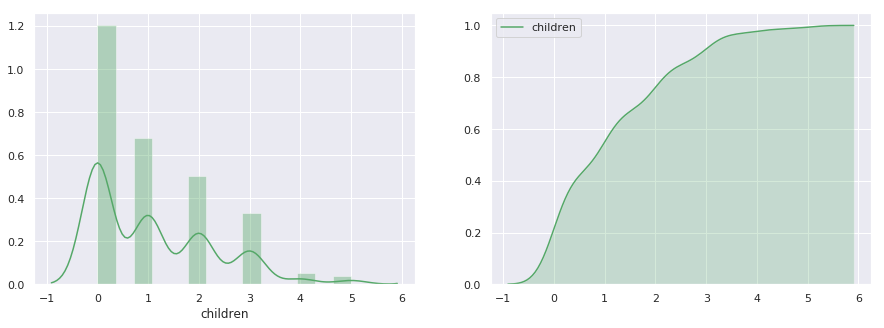

In [14]:
f, ax = plt.subplots(ncols = 2, figsize=(15,5))
sns.distplot(data['children'], color='g', ax=ax[0])
sns.kdeplot(data['children'], cumulative=True, shade=True, color='g', ax=ax[1])
print(data['children'].describe())

In [15]:
children_tab = pd.crosstab(index=data['children'], columns='Count', colnames=['Frequency'])
children_tab_percentage = children_tab/children_tab.sum()
print('{}\n\n{}'.format(children_tab, children_tab_percentage))

Frequency  Count
children        
0            574
1            324
2            240
3            157
4             25
5             18

Frequency     Count
children           
0          0.428999
1          0.242152
2          0.179372
3          0.117339
4          0.018685
5          0.013453


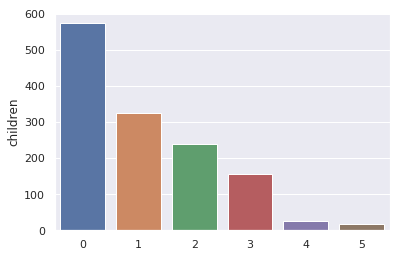

In [16]:
has_children = len(data[data['children'] > 0])/len(data)
sns.barplot(x=data['children'].value_counts().index, y=data['children'].value_counts(), data=data)

In [17]:
print('There are {:.3}% of patients with at least 1 or more children and {:.3}% without children'.format(has_children * 100, (1 - has_children) * 100))

There are 57.1% of patients with at least 1 or more children and 42.9% without children


### Categorical Univariate Analysis

**Sex**

Frequency  count
sex             
female       662
male         676

Frequency     count
sex                
female     0.494768
male       0.505232


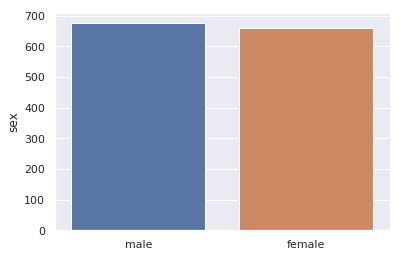

In [18]:
sex_tab = pd.crosstab(index=data['sex'], columns='count', colnames=['Frequency'])
sex_tab_percentage = sex_tab/sex_tab.sum()
print('{}\n\n{}'.format(sex_tab, sex_tab_percentage))
sns.barplot(x=data['sex'].value_counts().index, y=data['sex'].value_counts(), data=data)

- The distribution is approximately equal between male and female

**Smoker**

Frequency  count
smoker          
no          1064
yes          274

Frequency     count
smoker             
no         0.795217
yes        0.204783


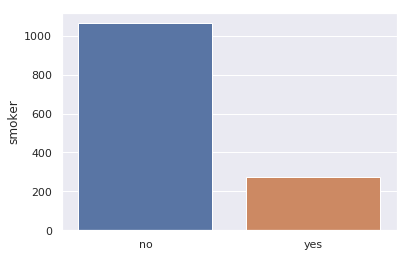

In [19]:
smoker_tab = pd.crosstab(index=data['smoker'], columns='count', colnames=['Frequency'])
smoker_tab_percentage = smoker_tab/smoker_tab.sum()
print('{}\n\n{}'.format(smoker_tab, smoker_tab_percentage))
sns.barplot(x=data['smoker'].value_counts().index, y=data['smoker'].value_counts(), data=data)

- 20.48% of patients are smokers

# Bivariate Analysis

Text(0.5, 1.0, 'Medical Costs of Males and Females')

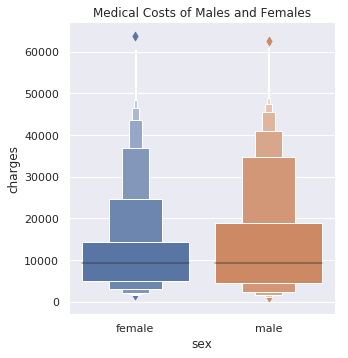

In [20]:
sns.catplot(x='sex', y='charges', kind='boxen', data=data)
plt.title('Medical Costs of Males and Females')

- Males have higher medical costs than females

Text(0.5, 1.0, 'Medical Costs of smokers and non-smokers for males and females')

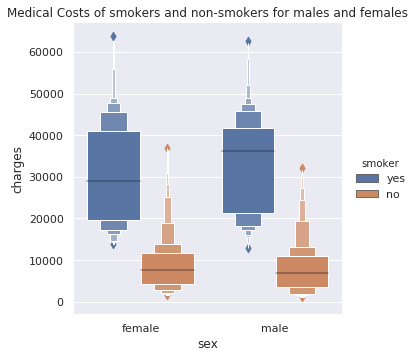

In [21]:
sns.catplot(x='sex', y='charges', kind='boxen', hue='smoker', data=data)
plt.title('Medical Costs of smokers and non-smokers for males and females')

- Patients who smoke have significantly higher medical costs than non-smokers

Text(0.5, 1.0, 'BMI of Males and Females')

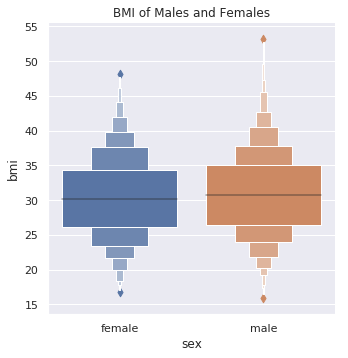

In [22]:
sns.catplot(x='sex', y='bmi', kind='boxen', data=data)
plt.title('BMI of Males and Females')

- Males and females have roughly the same bmi distribution

Text(0.5, 1.0, 'Medical Costs of different regions')

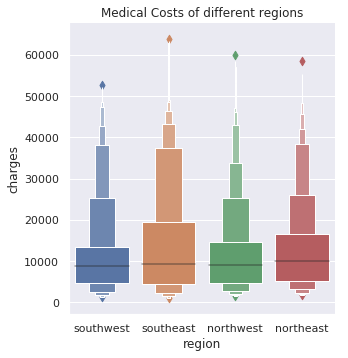

In [23]:
sns.catplot(x='region', y='charges', kind='boxen', data=data)
plt.title('Medical Costs of different regions')

Text(0.5, 1.0, 'Medical Costs of different regions for males and females')

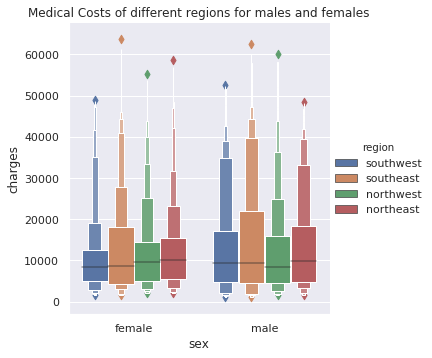

In [24]:
sns.catplot(x='sex', y='charges', kind='boxen', hue='region', data=data)
plt.title('Medical Costs of different regions for males and females')

- Males on average have higher medical costs at all regions than females except at northeast

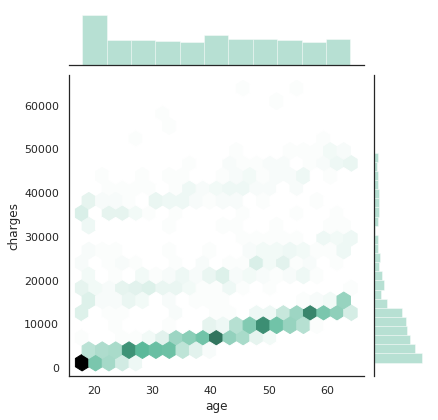

In [25]:
# Distribution of charges by age
with sns.axes_style("white"):
    sns.jointplot(x='age',y='charges',data=data, kind='hex', color='#4CB391')

- We can see a tendency that as age increases, the medical cost charges increases

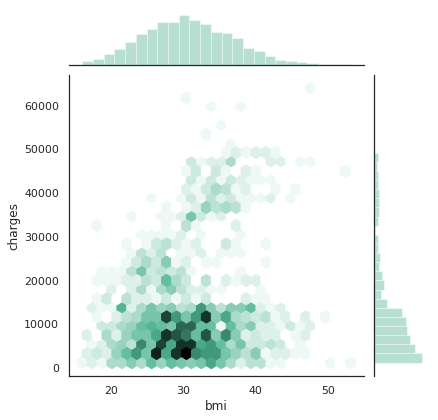

In [26]:
# Distribution of charges by bmi
with sns.axes_style("white"):
    sns.jointplot(x='bmi',y='charges',data=data, kind='hex', color='#4CB391')

Text(0.5, 1.0, 'Correlation Matrix')

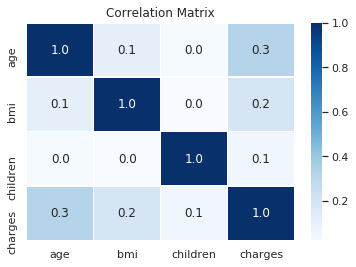

In [27]:
sns.heatmap(train.corr(), annot=True, linewidths=0.5, fmt='.1f', cmap='Blues')
plt.title('Correlation Matrix')

There seems to not be a strong correlation among the numeric features

# Feature Engineering 

![](https://www.ammfitness.co.uk/information-advice/wp-content/uploads/2019/04/bmi-chart.jpg)

**BMI Groups with respect to smokers and non-smokers**

Text(0.5, 1.0, 'Smokers')

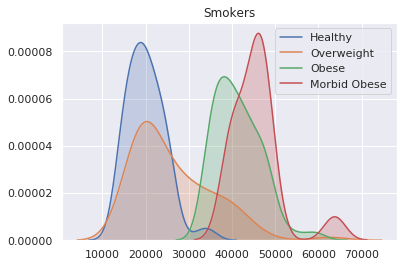

In [28]:
data['bmi_risk'] = np.where(data.bmi < 26, 'Healthy', 
                           np.where((data.bmi > 25) & (data.bmi < 31), 'Overweight', 
                                   np.where((data.bmi > 30) & (data.bmi < 41), 'Obese',
                                           np.where(data.bmi > 40, 'Morbid Obese', data['bmi']))))

y_healthy_smoker_yes = data[(data['bmi_risk'] == 'Healthy') & (data.smoker=='yes')].charges
y_overweight_smoker_yes = data[(data['bmi_risk'] == 'Overweight') & (data.smoker=='yes')].charges
y_obese_smoker_yes = data[(data['bmi_risk'] == 'Obese') & (data.smoker=='yes')].charges
y_morbid_smoker_yes = data[(data['bmi_risk'] == 'Morbid Obese') & (data.smoker=='yes')].charges

sns.kdeplot(y_healthy_smoker_yes, shade=True, label='Healthy')
sns.kdeplot(y_overweight_smoker_yes, shade=True, label='Overweight')
sns.kdeplot(y_obese_smoker_yes, shade=True, label='Obese')
sns.kdeplot(y_morbid_smoker_yes, shade=True, label='Morbid Obese')
plt.title('Smokers')

Text(0.5, 1.0, 'Non-Smokers')

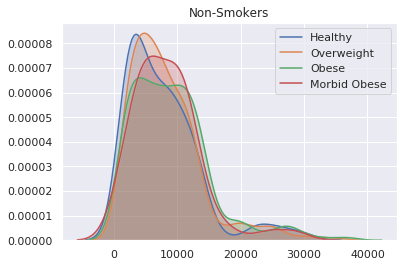

In [29]:
y_healthy_smoker_no = data[(data['bmi_risk'] == 'Healthy') & (data.smoker=='no')].charges
y_overweight_smoker_no = data[(data['bmi_risk'] == 'Overweight') & (data.smoker=='no')].charges
y_obese_smoker_no = data[(data['bmi_risk'] == 'Obese') & (data.smoker=='no')].charges
y_morbid_smoker_no = data[(data['bmi_risk'] == 'Morbid Obese') & (data.smoker=='no')].charges

sns.kdeplot(y_healthy_smoker_no, shade=True, label='Healthy')
sns.kdeplot(y_overweight_smoker_no, shade=True, label='Overweight')
sns.kdeplot(y_obese_smoker_no, shade=True, label='Obese')
sns.kdeplot(y_morbid_smoker_no, shade=True, label='Morbid Obese')
plt.title('Non-Smokers')

The distribution charges for patients of different BMIs are all similar for non smokers. However, there are clear groups for smokers where each group with an worse bmi have increased charges.

# Transformations

In [30]:
print('Skew:\n{}\n\nKurtosis:\n{}'.format(train.skew(),train.kurt()))

Skew:
age         0.025624
bmi         0.269498
children    0.939411
charges     1.496398
dtype: float64

Kurtosis:
age        -1.258371
bmi        -0.115496
children    0.195094
charges     1.503891
dtype: float64


Charges has high positive skew. I will apply boxcox transformations to reduce the skewness


 mu = 13214.13 and sigma = 12028.18



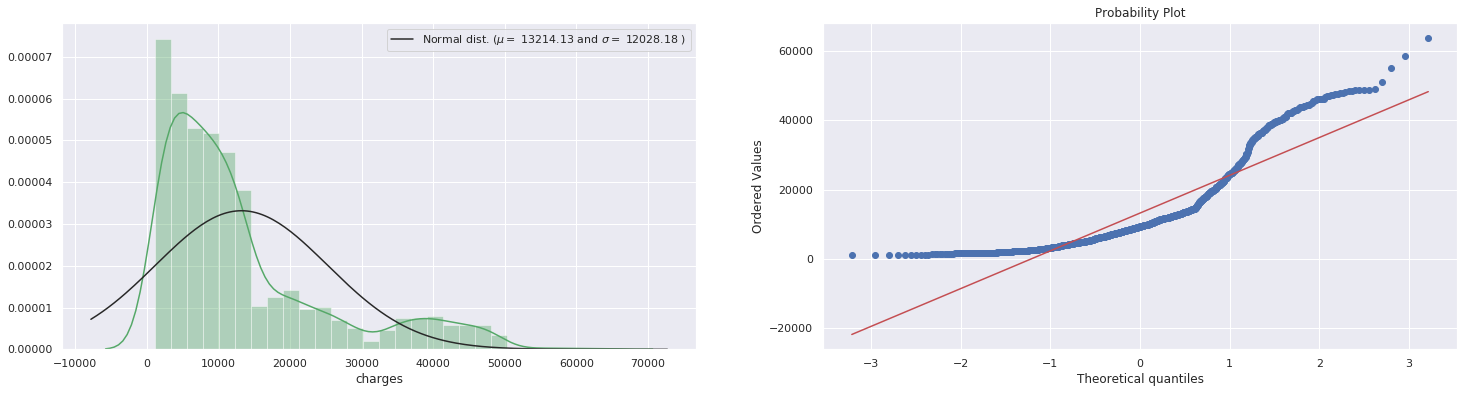

In [31]:
f, ax = plt.subplots(ncols=2, figsize=(25,6))

# distribution of charges
g1 = sns.distplot(train['charges'], fit=stats.norm, ax=ax[0], color='g')

# Get fitted parameters used by the function
(mu, sigma) = stats.norm.fit(train['charges'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# plot the following distribution
g1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('charges distribution')

# plot the QQ-plot
res = stats.probplot(train['charges'], plot=plt)

**Apply boxcox transformation**


 mu = 11.51 and sigma = 1.44



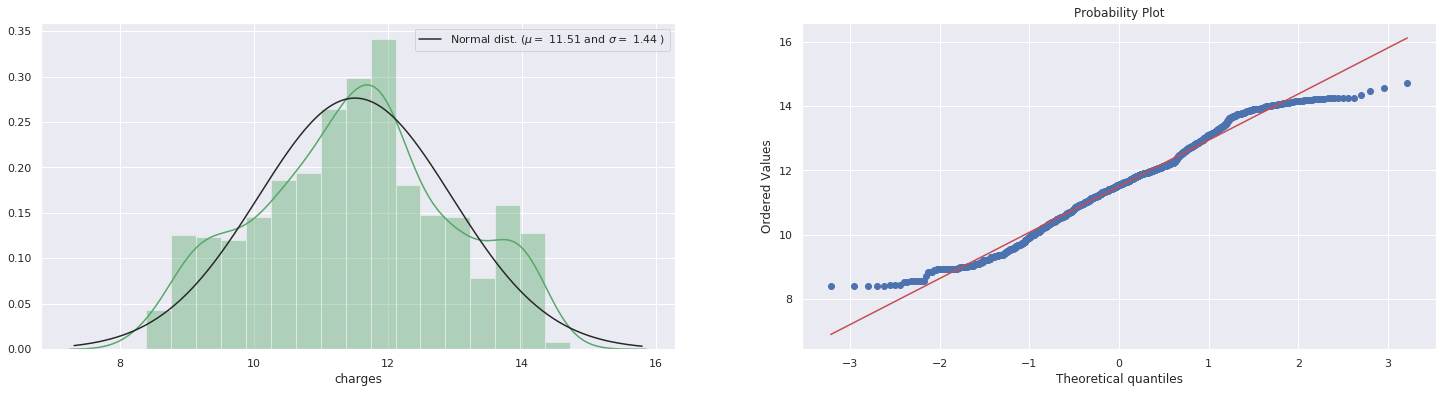

In [32]:
# Apply boxcox transformation
train["charges"],  maxlog = stats.boxcox(train["charges"])

# distribution of charges
f, ax = plt.subplots(ncols=2, figsize=(25,6))
g1 = sns.distplot(train['charges'], fit=stats.norm, ax=ax[0], color='g')

# Get fitted parameters used by the function
(mu, sigma) = stats.norm.fit(train['charges'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# plot the distribution
g1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('charges distribution')

# plot the QQ-plot
res = stats.probplot(train['charges'], plot=plt)

# In-depth Regression Analysis

To see an [in-depth regression analysis](https://www.kaggle.com/littleotter/medical-costs-in-depth-regression-analysis) where I perform feature engineering, add polynomial terms, model selection, feature selection, hyperparater tuning, and model evaluation, I encourage you to follow the given link.